# GPyTorch regression with derivative information in 2d

## Introduction
In this notebook, we show how to train a GP regression model in GPyTorch of a 2-dimensional function given function values and derivative observations. We consider modeling the Franke function where the values and derivatives are contaminated with independent $\mathcal{N}(0, 0.5)$ distributed noise.

In [1]:
import torch
import gpytorch
import math
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Franke function
The following is a vectorized implementation of the 2-dimensional Franke function (https://www.sfu.ca/~ssurjano/franke2d.html)

In [2]:
def franke(X, Y):
    term1 = .75*torch.exp(-((9*X - 2).pow(2) + (9*Y - 2).pow(2))/4)
    term2 = .75*torch.exp(-((9*X + 1).pow(2))/49 - (9*Y + 1)/10)
    term3 = .5*torch.exp(-((9*X - 7).pow(2) + (9*Y - 3).pow(2))/4)
    term4 = .2*torch.exp(-(9*X - 4).pow(2) - (9*Y - 7).pow(2))
    
    f = term1 + term2 + term3 - term4
    dfx = -2*(9*X - 2)*9/4 * term1 - 2*(9*X + 1)*9/49 * term2 + \
          -2*(9*X - 7)*9/4 * term3 + 2*(9*X - 4)*9 * term4
    dfy = -2*(9*Y - 2)*9/4 * term1 - 9/10 * term2 + \
          -2*(9*Y - 3)*9/4 * term3 + 2*(9*Y - 7)*9 * term4
    
    return f, dfx, dfy

## Setting up the training data
We use a grid with 100 points in $[0,1] \times [0,1]$ with 10 uniformly distributed points per dimension.

In [3]:
xv, yv = torch.meshgrid([torch.linspace(0, 1, 10), torch.linspace(0, 1, 10)])
train_x = torch.cat((
    xv.contiguous().view(xv.numel(), 1), 
    yv.contiguous().view(yv.numel(), 1)),
    dim=1
)

f, dfx, dfy = franke(train_x[:, 0], train_x[:, 1])
train_y = torch.stack([f, dfx, dfy], -1).squeeze(1)
train_y += 0.05 * torch.randn(train_y.size())

## Setting up the model
A GP prior on the function values implies a multi-output GP prior on the function values and the partial derivatives, see 9.4 in http://www.gaussianprocess.org/gpml/chapters/RW9.pdf for more details. This allows using a `MultitaskMultivariateNormal` and `MultitaskGaussianLikelihood` to train a GP model from both function values and gradients. The resulting RBF kernel that models the covariance between the values and partial derivatives has been implemented in `RBFKernelGrad` and the extension of a constant mean is implemented in `ConstantMeanGrad`.

The `RBFKernelGrad` is generally worse conditioned than the `RBFKernel`, so we place a lower bound on the noise parameter to keep the smallest eigenvalues of the kernel matrix away from zero.

In [4]:
class GPModelWithDerivatives(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModelWithDerivatives, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMeanGrad()
        self.base_kernel = gpytorch.kernels.RBFKernelGrad()
        self.covar_module = gpytorch.kernels.ScaleKernel(self.base_kernel)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3)  # Value + x-derivative + y-derivative
likelihood.initialize(noise=0.01*train_y.std())  # Require 1% noise (approximately)
likelihood.raw_noise.requires_grad = False
model = GPModelWithDerivatives(train_x, train_y, likelihood)

## Training the model
The model training is similar to training a standard GP regression model

In [5]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 50
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
        i + 1, n_iter, loss.item(),
        model.covar_module.base_kernel.log_lengthscale.item(),
        model.likelihood.log_noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 110.857   log_lengthscale: -0.367   log_noise: -4.709
Iter 2/50 - Loss: 107.436   log_lengthscale: -0.439   log_noise: -4.709
Iter 3/50 - Loss: 103.931   log_lengthscale: -0.514   log_noise: -4.709
Iter 4/50 - Loss: 98.777   log_lengthscale: -0.590   log_noise: -4.709
Iter 5/50 - Loss: 96.182   log_lengthscale: -0.668   log_noise: -4.709
Iter 6/50 - Loss: 90.462   log_lengthscale: -0.748   log_noise: -4.709
Iter 7/50 - Loss: 87.768   log_lengthscale: -0.829   log_noise: -4.709
Iter 8/50 - Loss: 81.940   log_lengthscale: -0.912   log_noise: -4.709
Iter 9/50 - Loss: 77.007   log_lengthscale: -0.996   log_noise: -4.709
Iter 10/50 - Loss: 71.270   log_lengthscale: -1.081   log_noise: -4.709
Iter 11/50 - Loss: 73.652   log_lengthscale: -1.162   log_noise: -4.709
Iter 12/50 - Loss: 71.459   log_lengthscale: -1.224   log_noise: -4.709
Iter 13/50 - Loss: 66.044   log_lengthscale: -1.263   log_noise: -4.709
Iter 14/50 - Loss: 65.438   log_lengthscale: -1.284   log_noise: -4.70

## Making predictions with the model
Model predictions are also similar to GP regression with only function values, but we need more CG iterations to get accurate estimates of the predictive variance

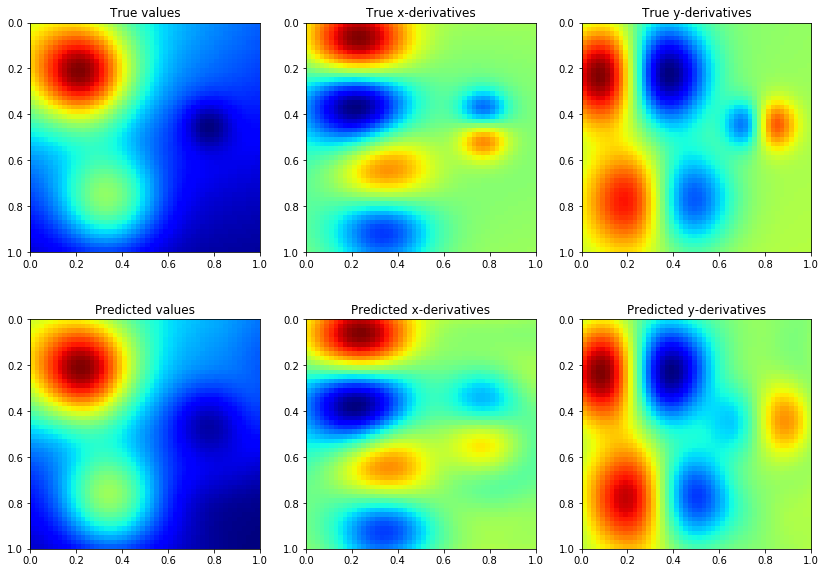

In [6]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
fig, ax = plt.subplots(2, 3, figsize=(14, 10))

# Test points
n1, n2 = 50, 50
xv, yv = torch.meshgrid([torch.linspace(0, 1, n1), torch.linspace(0, 1, n2)])
f, dfx, dfy = franke(xv, yv)

# Make predictions
with torch.no_grad(), gpytorch.settings.max_cg_iterations(50):
    test_x = torch.stack([xv.reshape(n1*n2, 1), yv.reshape(n1*n2, 1)], -1).squeeze(1)
    predictions = likelihood(model(test_x))
    mean = predictions.mean

extent = (xv.min(), xv.max(), yv.max(), yv.min())
ax[0, 0].imshow(f, extent=extent, cmap=cm.jet)
ax[0, 0].set_title('True values')
ax[0, 1].imshow(dfx, extent=extent, cmap=cm.jet)
ax[0, 1].set_title('True x-derivatives')
ax[0, 2].imshow(dfy, extent=extent, cmap=cm.jet)
ax[0, 2].set_title('True y-derivatives')

ax[1, 0].imshow(mean[:, 0].detach().numpy().reshape(n1, n2), extent=extent, cmap=cm.jet)
ax[1, 0].set_title('Predicted values')
ax[1, 1].imshow(mean[:, 1].detach().numpy().reshape(n1, n2), extent=extent, cmap=cm.jet)
ax[1, 1].set_title('Predicted x-derivatives')
ax[1, 2].imshow(mean[:, 2].detach().numpy().reshape(n1, n2), extent=extent, cmap=cm.jet)
ax[1, 2].set_title('Predicted y-derivatives')

None